In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')


In [2]:
happiness_df = pd.read_csv('WorldHappiness.csv')
flags_df = pd.read_csv('flags.csv', sep=';')

happiness_df['Country'] = happiness_df['Country'].str.strip().str.lower()
flags_df['name'] = flags_df['name'].str.strip().str.lower()
merged_df = pd.merge(happiness_df, flags_df, left_on='Country', right_on='name', how='inner')
merged_df.columns = merged_df.columns.str.strip()
print(f"Merged shape: {merged_df.shape}")


Merged shape: (104, 43)


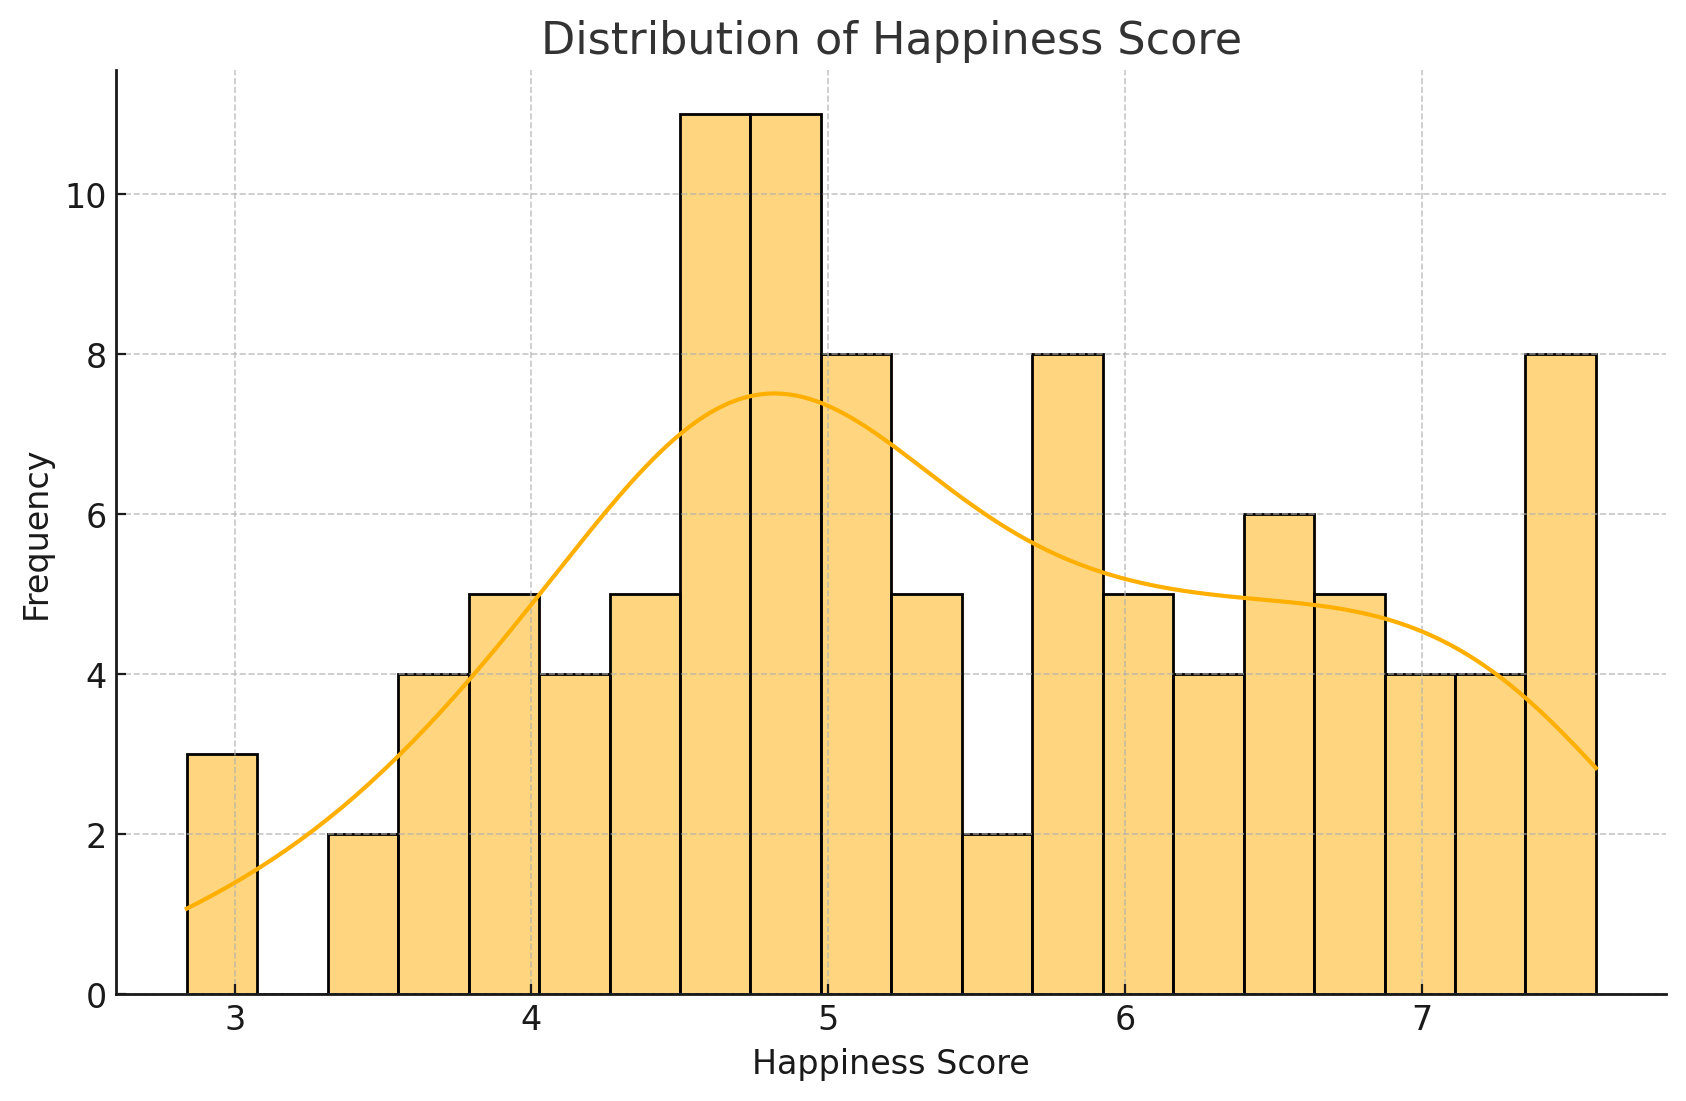

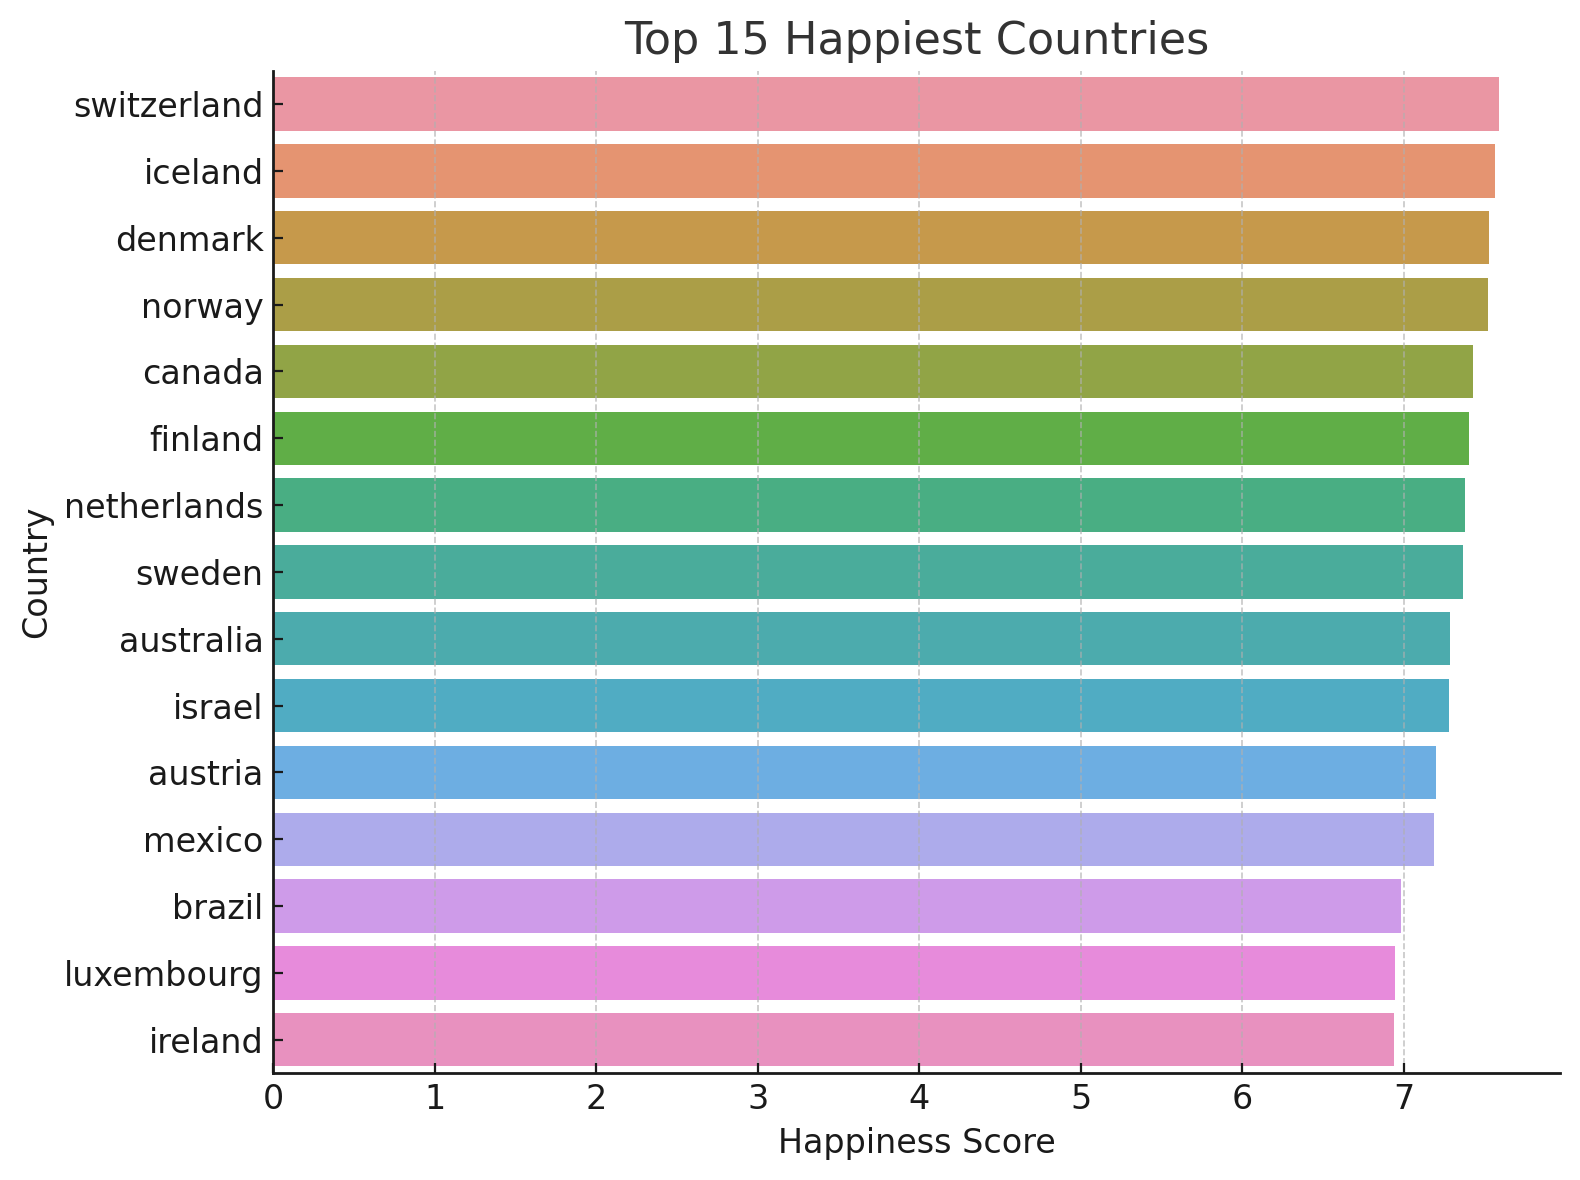

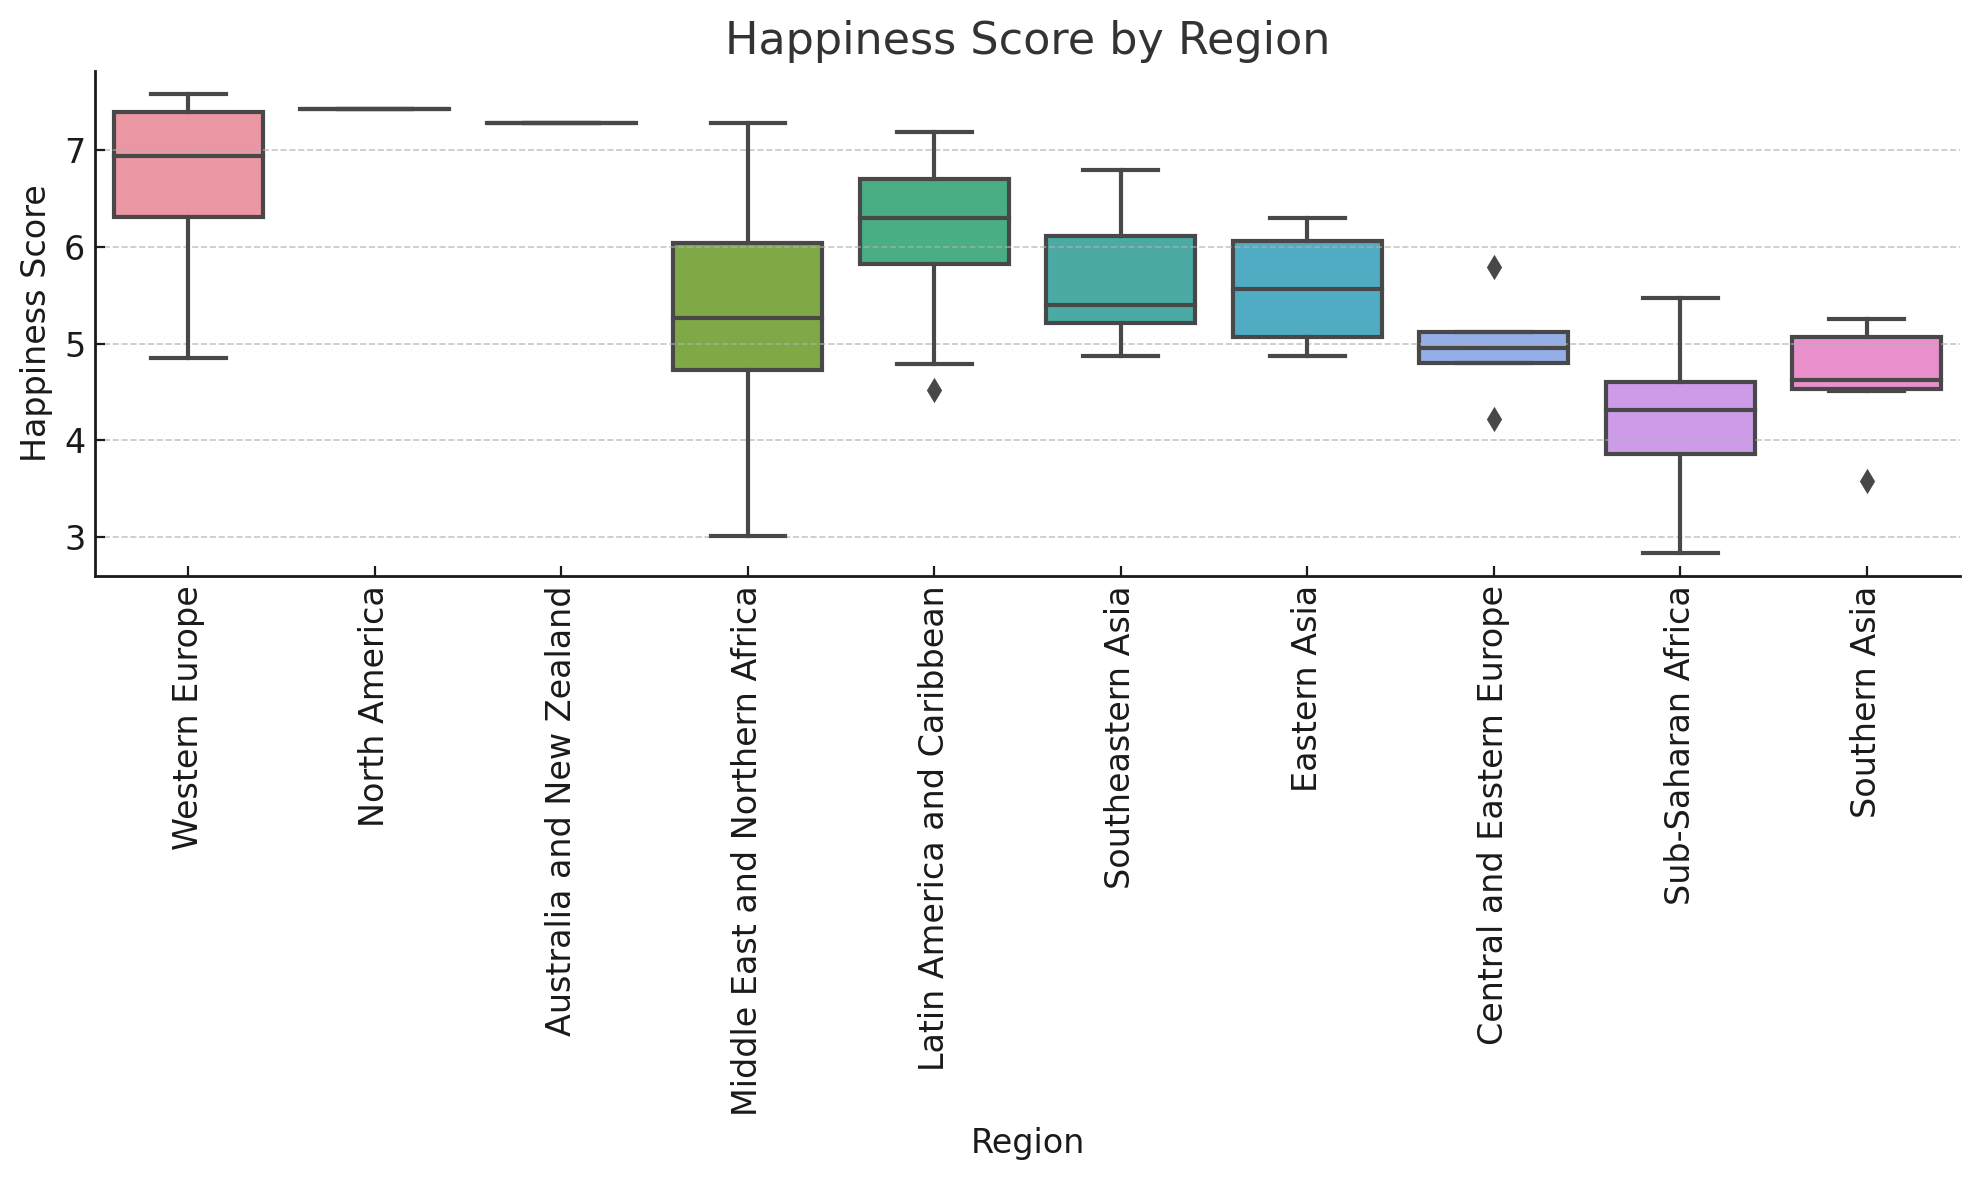

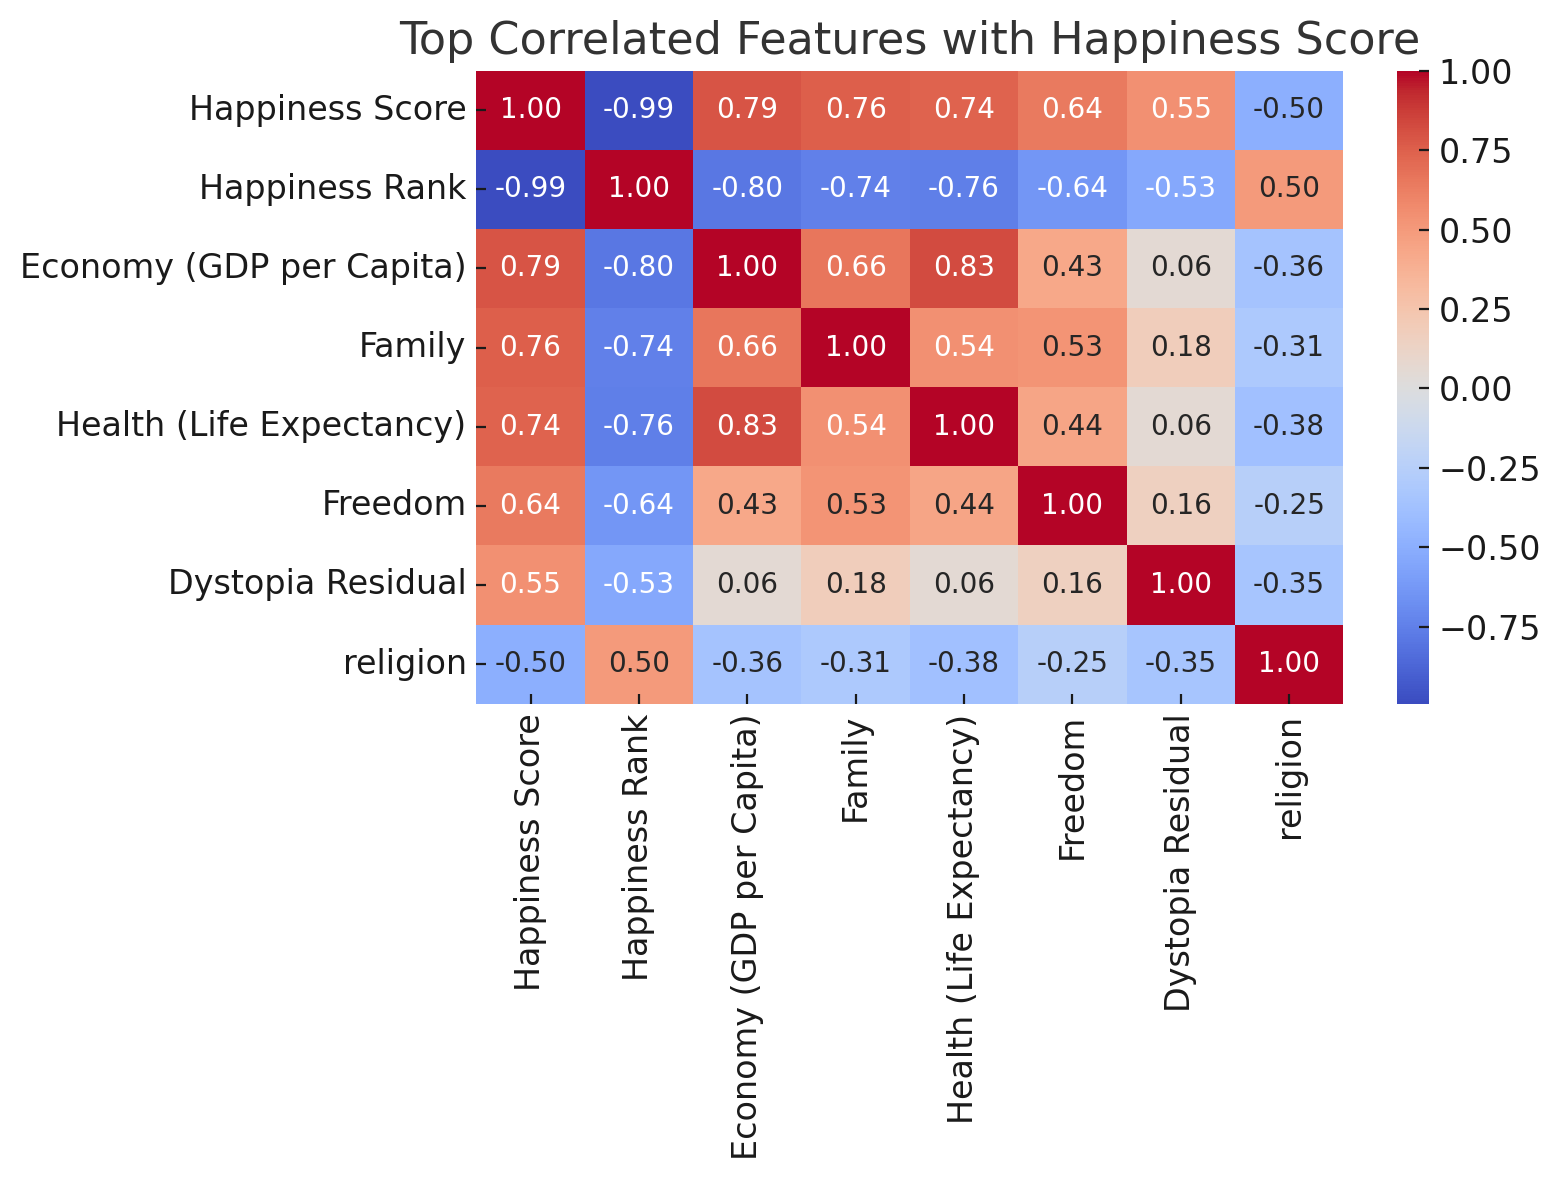

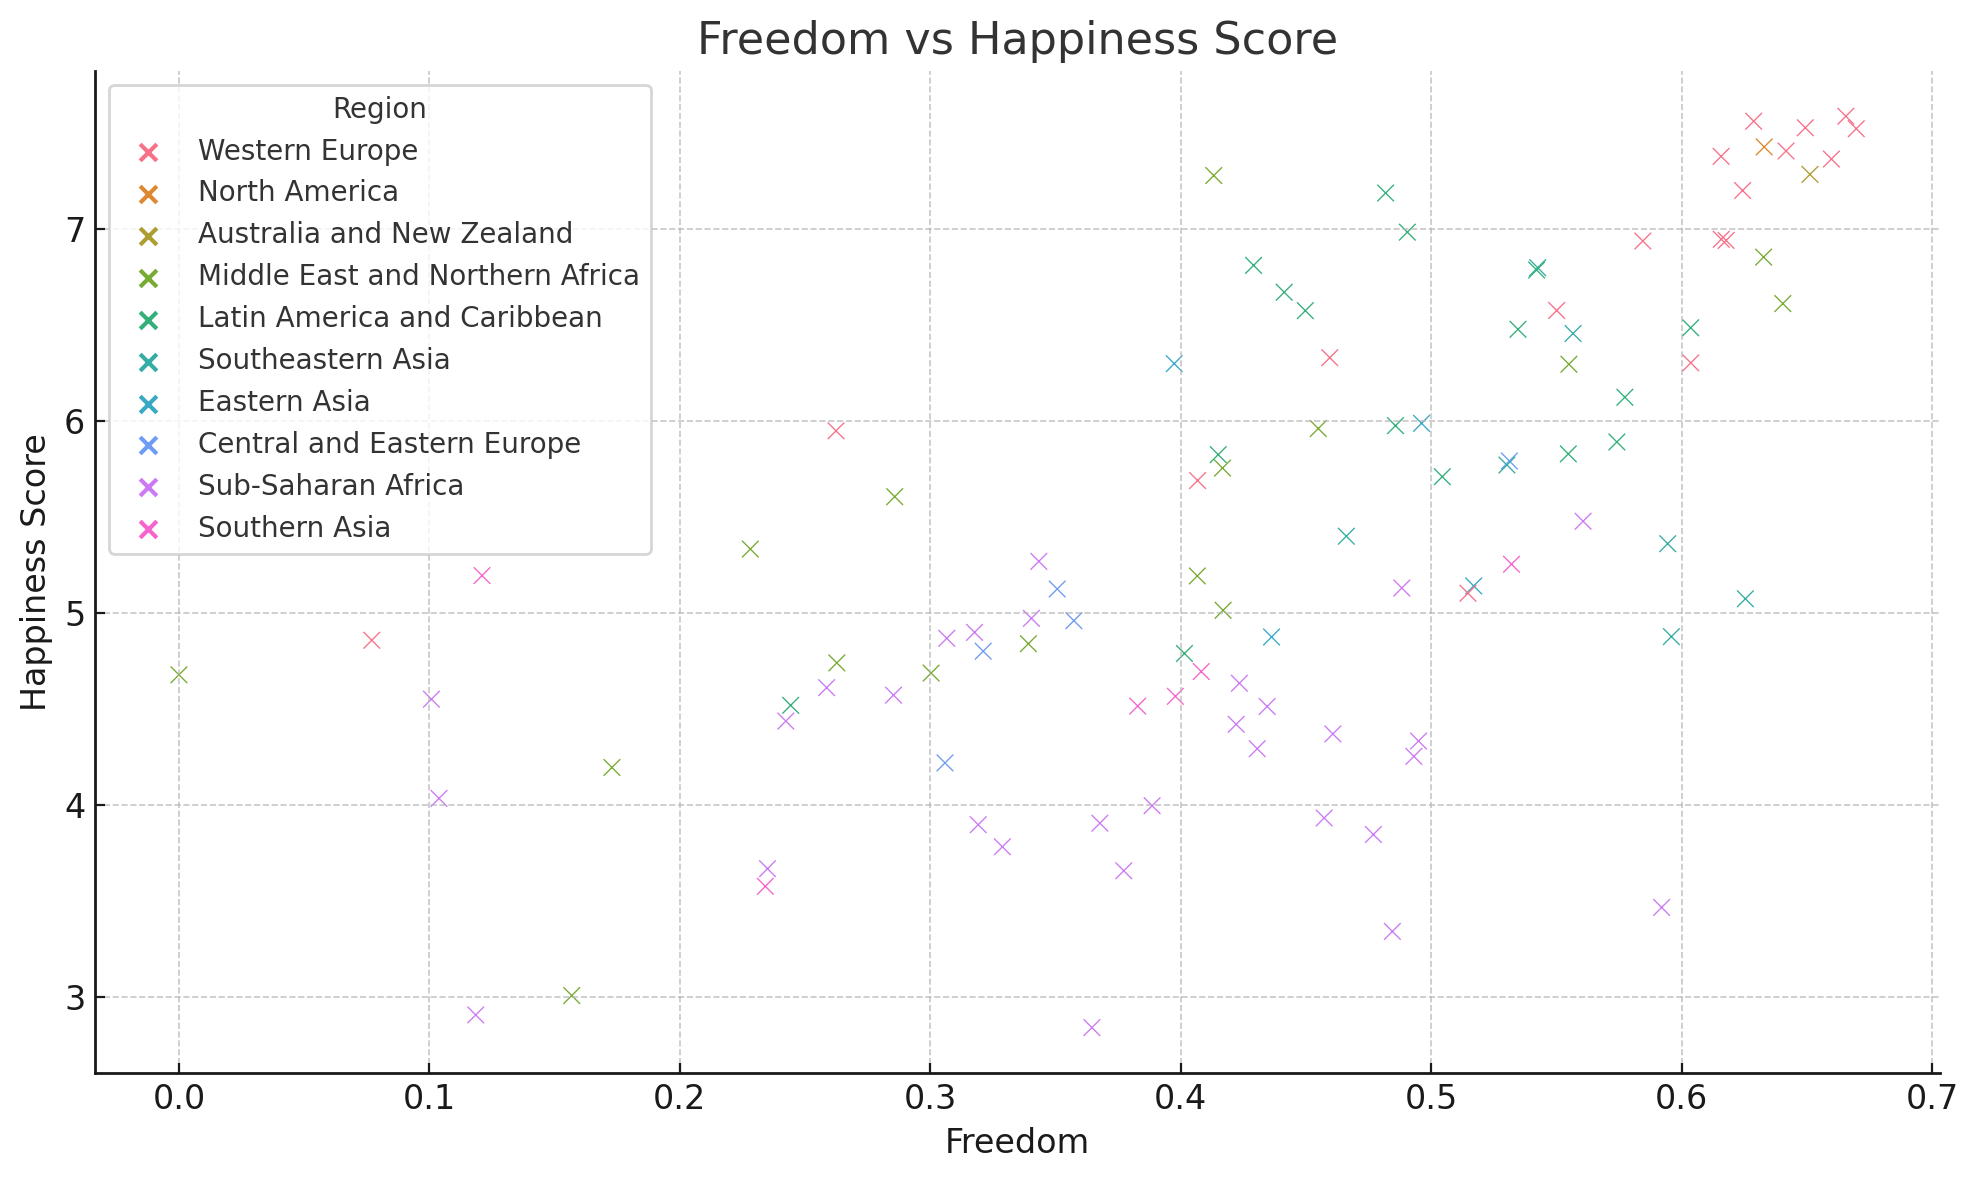

Pearson r: 0.6429, p-value: 0.000000


In [3]:
# 1. Histogram of Happiness Score
plt.figure()
sns.histplot(merged_df['Happiness Score'], bins=20, kde=True)
plt.title('Distribution of Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.show()

# 2. Top 15 Happiest Countries
plt.figure(figsize=(8,6))
top15 = merged_df.sort_values(by='Happiness Score', ascending=False).head(15)
sns.barplot(data=top15, y='Country', x='Happiness Score')
plt.title('Top 15 Happiest Countries')
plt.xlabel('Happiness Score')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# 3. Happiness Score by Region
plt.figure(figsize=(10,6))
sns.boxplot(data=merged_df, x='Region', y='Happiness Score')
plt.title('Happiness Score by Region')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4. Simplified Correlation Heatmap
corr = merged_df.select_dtypes(include='number').corr()
top_features = corr['Happiness Score'].abs().sort_values(ascending=False).head(8).index
subcorr = corr.loc[top_features, top_features]
plt.figure(figsize=(8,6))
sns.heatmap(subcorr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Top Correlated Features with Happiness Score')
plt.tight_layout()
plt.show()

# 5. Freedom vs Happiness
plt.figure()
sns.scatterplot(data=merged_df, x='Freedom', y='Happiness Score', hue='Region')
plt.title('Freedom vs Happiness Score')
plt.tight_layout()
plt.show()

r, p = pearsonr(merged_df['Freedom'], merged_df['Happiness Score'])
print(f"Pearson r: {r:.4f}, p-value: {p:.6f}")


In [4]:
# Convert to binary classes
median_score = merged_df['Happiness Score'].median()
merged_df['Happiness_Level'] = merged_df['Happiness Score'].apply(lambda x: 'high' if x >= median_score else 'low')

# Features and target
feature_cols = ['green', 'blue', 'gold', 'white', 'black',
                'circles', 'crosses', 'saltires', 'quarters',
                'sunstars', 'crescent', 'triangle', 'icon', 'animate']
X = merged_df[feature_cols]
y = merged_df['Happiness_Level']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Accuracy: 0.5714285714285714

Classification Report:
               precision    recall  f1-score   support

        high       0.62      0.45      0.53        11
         low       0.54      0.70      0.61        10

    accuracy                           0.57        21
   macro avg       0.58      0.58      0.57        21
weighted avg       0.58      0.57      0.57        21


Confusion Matrix:
 [[5 6]
 [3 7]]


Cross-Validation Accuracy Scores: [0.9047619  0.42857143 0.80952381 0.66666667 0.65      ]
Mean Accuracy: 0.6919047619047618
